<a href="https://colab.research.google.com/github/kiranelai/Internship/blob/main/BILSTM(combined).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from datetime import datetime
from datetime import timedelta
from time import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/elai/combined_dataset.csv')

In [ ]:
df.head()

,Price Date,Max Price
0,02-01-2010,2350
1,04-01-2010,2000
2,05-01-2010,1601
3,06-01-2010,1755
4,07-01-2010,1900


In [ ]:
df['Price Date'] = pd.to_datetime(df['Price Date'], format='%d-%m-%Y')

In [ ]:
df.set_index('Price Date', inplace=True)

In [ ]:
# Calculate the mean of 'Max Price' for each unique 'Price Date'
df = df.groupby('Price Date')['Max Price'].mean().reset_index()

In [ ]:
df.head(20)

,Price Date,Max Price
0,2010-01-02,2350.0
1,2010-01-04,2000.0
2,2010-01-05,1601.0
3,2010-01-06,1755.0
4,2010-01-07,1820.5
5,2010-01-09,1900.0
6,2010-01-11,1600.5
7,2010-01-12,1454.0
8,2010-01-13,1481.0
9,2010-01-14,1850.0


In [ ]:
df.dtypes

Price Date    datetime64[ns]
Max Price            float64
dtype: object

In [ ]:
df.set_index('Price Date', inplace=True)

In [ ]:
df.head()

,Max Price
Price Date,
2010-01-02,2350.0
2010-01-04,2000.0
2010-01-05,1601.0
2010-01-06,1755.0
2010-01-07,1820.5


In [ ]:
ts_data = df[['Max Price']].copy()
ts_data = ts_data.asfreq('D')  # Set the frequency to daily
# Fill missing values using linear interpolation
ts_data = ts_data.interpolate(method='linear')
# Optionally, you can also perform backfill (use the next available value)
# for any remaining missing values at the beginning of the time series
ts_data = ts_data.bfill()
if ts_data.isnull().values.any():
  ts_data = ts_data.fillna(method='ffill')

In [ ]:
ts_data.head()

,Max Price
Price Date,
2010-01-02,2350.0
2010-01-03,2175.0
2010-01-04,2000.0
2010-01-05,1601.0
2010-01-06,1755.0


In [ ]:
len(ts_data)

4747

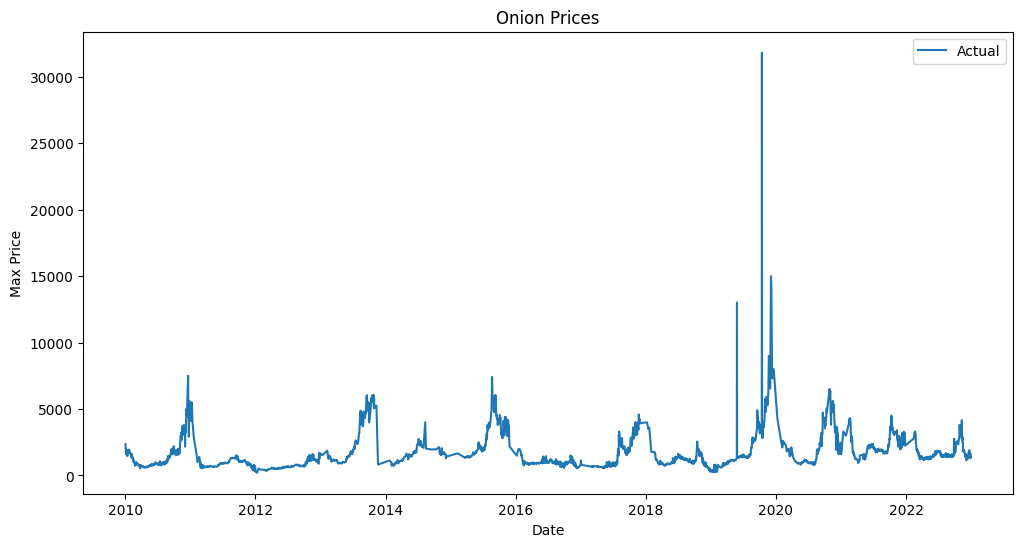

In [ ]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(ts_data.index, ts_data['Max Price'], label='Actual')
plt.xlabel('Date')
plt.ylabel('Max Price')
plt.title('Onion Prices')
plt.legend()
plt.show()

In [ ]:
# Perform seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_data['Max Price'], model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

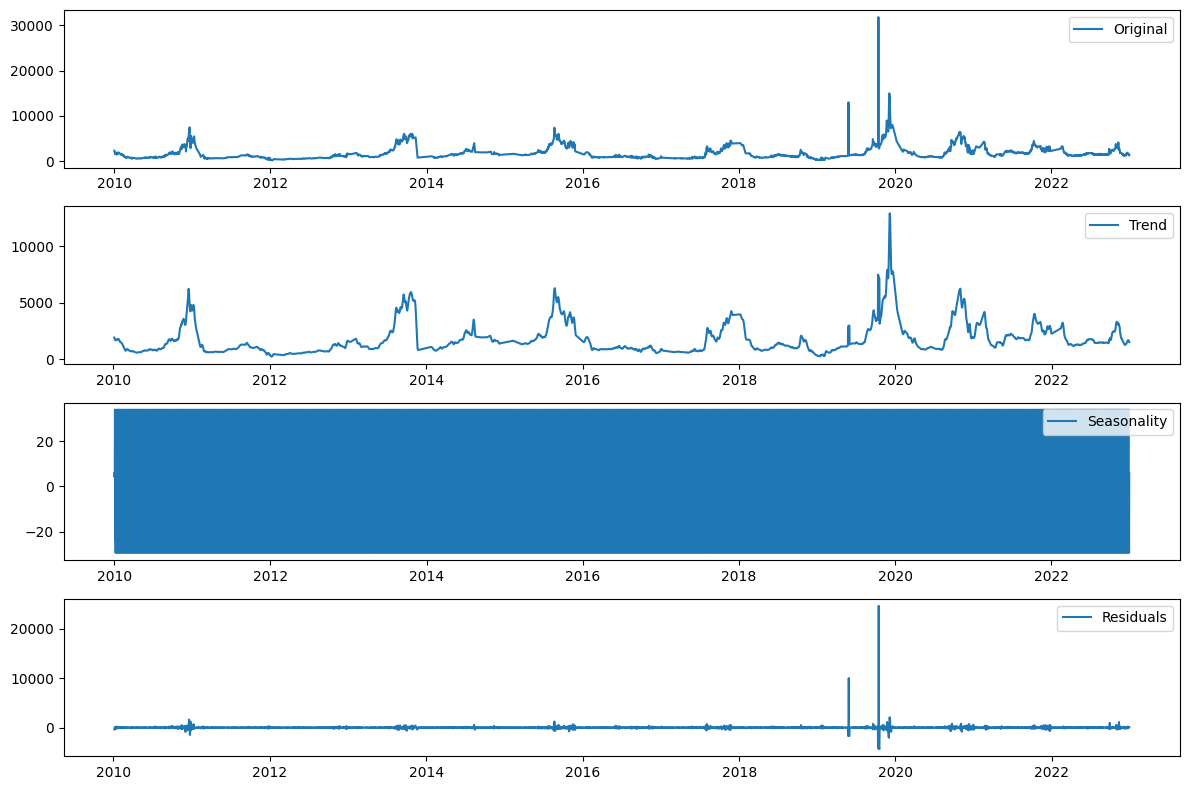

In [ ]:
# Plot the decomposition components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(ts_data.index, ts_data['Max Price'], label='Original')
plt.legend()
plt.subplot(412)
plt.plot(ts_data.index, trend, label='Trend')
plt.legend()
plt.subplot(413)
plt.plot(ts_data.index, seasonal, label='Seasonality')
plt.legend()
plt.subplot(414)
plt.plot(ts_data.index, residual, label='Residuals')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Test for stationarity
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

In [ ]:
# Test stationarity of the original series
test_stationarity(ts_data['Max Price'])

Results of Dickey-Fuller Test:
Test Statistic                   -4.561370
p-value                           0.000152
Lags Used                        10.000000
Number of Observations Used    4736.000000
Critical Value (1%)              -3.431732
Critical Value (5%)              -2.862150
Critical Value (10%)             -2.567095
dtype: float64


In [ ]:
series1=ts_data['Max Price']

In [ ]:
# Create train and test sets
train_size = int(len(ts_data) * 0.9)
train_data = series1[:train_size]
test_data = series1[train_size:]

In [ ]:
len(train_data)

4272

In [ ]:
len(test_data)

475

In [ ]:
# Scale the data
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))

In [ ]:
# Define the number of time steps and create input sequences
n_steps = 30
X_train = []
y_train = []
for i in range(n_steps, len(scaled_train_data)):
    X_train.append(scaled_train_data[i - n_steps:i, 0])
    y_train.append(scaled_train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Reshape input sequences for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
# Build the BiLSTM model
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True, input_shape=(n_steps, 1))))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
133/133 [==============================] - 11s 36ms/step - loss: 5.5877e-04
Epoch 2/50
133/133 [==============================] - 5s 39ms/step - loss: 3.8507e-04
Epoch 3/50
133/133 [==============================] - 4s 33ms/step - loss: 3.9099e-04
Epoch 4/50
133/133 [==============================] - 6s 43ms/step - loss: 3.7237e-04
Epoch 5/50
133/133 [==============================] - 4s 33ms/step - loss: 3.6449e-04
Epoch 6/50
133/133 [==============================] - 4s 32ms/step - loss: 3.6557e-04
Epoch 7/50
133/133 [==============================] - 6s 43ms/step - loss: 3.6136e-04
Epoch 8/50
133/133 [==============================] - 4s 32ms/step - loss: 3.6800e-04
Epoch 9/50
133/133 [==============================] - 5s 36ms/step - loss: 3.5984e-04
Epoch 10/50
133/133 [==============================] - 5s 38ms/step - loss: 3.6103e-04
Epoch 11/50
133/133 [==============================] - 4s 32ms/step - loss: 3.6183e-04
Epoch 12/50
133/133 [==============================

In [ ]:
# Prepare test data
scaled_test_data = scaler.transform(test_data.values.reshape(-1, 1))
X_test = []
y_test = []
for i in range(n_steps, len(scaled_test_data)):
    X_test.append(scaled_test_data[i - n_steps:i, 0])
    y_test.append(scaled_test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Generate predictions
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

14/14 [==============================] - 2s 14ms/step


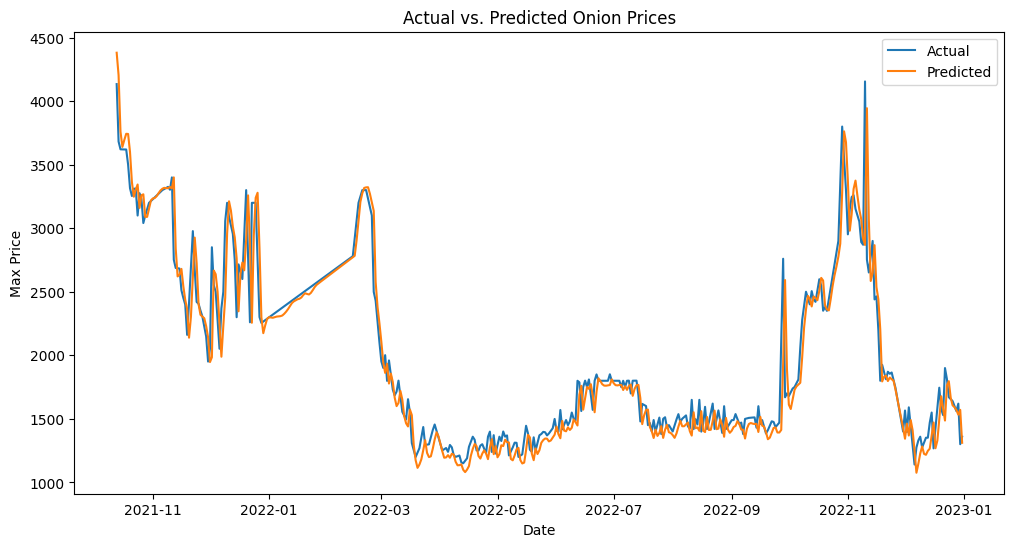

In [ ]:
# Plot test vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(ts_data.index[train_size + n_steps:train_size + n_steps + len(predicted_prices)], ts_data['Max Price'][train_size + n_steps:train_size + n_steps + len(predicted_prices)], label='Actual')
plt.plot(ts_data.index[train_size + n_steps:train_size + n_steps + len(predicted_prices)], predicted_prices[:, 0], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Max Price')
plt.title('Actual vs. Predicted Onion Prices')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE
mae = mean_absolute_error(ts_data['Max Price'][train_size + n_steps:train_size + n_steps + len(predicted_prices)], predicted_prices[:, 0])
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(ts_data['Max Price'][train_size + n_steps:train_size + n_steps + len(predicted_prices)], predicted_prices[:, 0]))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(ts_data['Max Price'][train_size + n_steps:train_size + n_steps + len(predicted_prices)], predicted_prices[:, 0])
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Mean Absolute Error (MAE): 116.77148218047753
Root Mean Squared Error (RMSE): 194.96622709276184
Mean Absolute Percentage Error (MAPE): 5.804077660255548%


In [ ]:
model.save('/content/drive/MyDrive/elai/onion_model')

In [ ]:
model.save('/content/drive/MyDrive/elai/onion_model.h5')

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/elai/onion_model.h5')

148/148 [==============================] - 2s 9ms/step


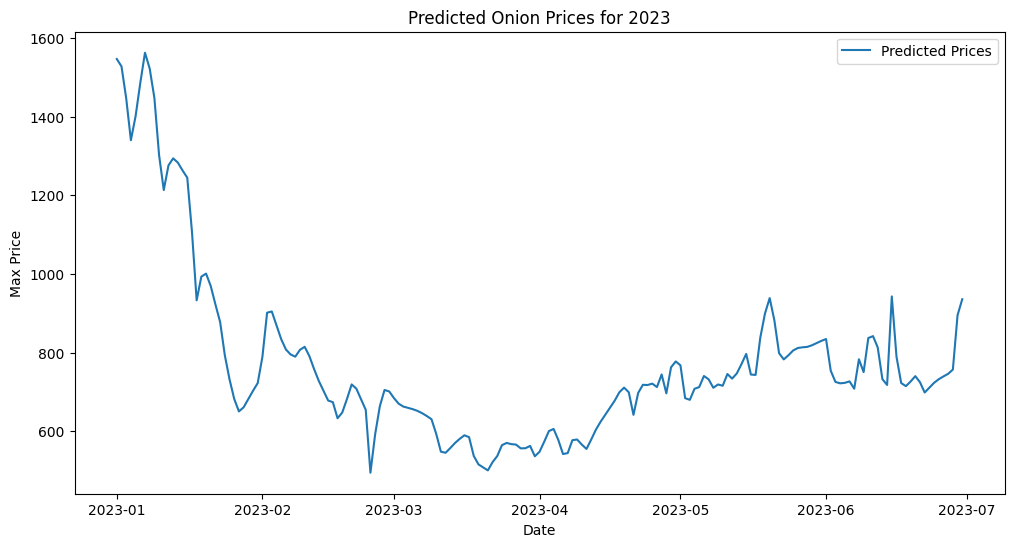

In [ ]:
# Prepare the input data for predicting 2023 prices
start_date_2023 = pd.to_datetime('2023-01-01')
end_date_2023 = pd.to_datetime('2023-06-30')
dates_2023 = pd.date_range(start=start_date_2023, end=end_date_2023, freq='D')

# Scale the input data
scaled_2023 = scaler.transform(ts_data['Max Price'].values.reshape(-1, 1))

# Reshape the input data to match the BiLSTM model's input shape
X_2023 = []
for i in range(n_steps, len(scaled_2023)):
    X_2023.append(scaled_2023[i - n_steps:i, 0])
X_2023 = np.array(X_2023)

# Predict the onion prices for 2023
predicted_prices = new_model.predict(X_2023.reshape(X_2023.shape[0], X_2023.shape[1], 1))

# Inverse scale the predicted prices
predicted_prices_2023 = scaler.inverse_transform(predicted_prices)

# Truncate the predicted prices array to match the length of dates_2023
predicted_prices_2023 = predicted_prices_2023[:len(dates_2023)]

# Create a DataFrame for the predicted prices
df_predicted_2023 = pd.DataFrame(data=predicted_prices_2023, index=dates_2023, columns=['Predicted Prices'])

# Plot the predicted prices for 2023
plt.figure(figsize=(12, 6))
plt.plot(df_predicted_2023.index, df_predicted_2023['Predicted Prices'], label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Max Price')
plt.title('Predicted Onion Prices for 2023')
plt.legend()
plt.show()

In [ ]:
df_predicted_2023

,Predicted Prices
2023-01-01,1467.897705
2023-01-02,1450.273682
2023-01-03,1376.659302
2023-01-04,1274.268555
2023-01-05,1316.692017
...,...
2023-06-26,625.101990
2023-06-27,630.764099
2023-06-28,640.275757
2023-06-29,761.523438
